# Experiments on the threshold value of TVLA

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

from src.tools.cache import cache_np
from src.tools.plotter import init_plots
from src.tvla.t import make_t_test
from numpy.random import default_rng

PRNG = default_rng()
init_plots()

In [2]:
def gen_trace(num_traces, trace_length):
    norm = PRNG.standard_normal((num_traces, trace_length))
    return (norm * 3).astype(np.int8)

def get_mv(traces):
    return traces.mean(axis=0), traces.var(axis=0)

In [3]:
def tp_values(trace_length=100000):
    # DoF simplified, as in the paper of Schneider & Moradi (2016, page 87)
    num_traces = 1000

    test = make_t_test(num_traces, num_traces)
    mv_a = get_mv(gen_trace(num_traces, trace_length))
    mv_b = get_mv(gen_trace(num_traces, trace_length))

    return test(*mv_a, *mv_b)

In [32]:
(1 - .00001) ** 1400

0.9860974752356388

In [38]:
NUM_TIMES = 250

def min_ps(graph_ix):
    threshold_p = 10 ** -5
    threshold_t = 4.5
    acc = np.zeros((len(graph_ix), 2))

    for ix, trace_length in enumerate(graph_ix):
        # Slower implementation, easier on the eyes of the reader.
        for _ in tqdm(range(NUM_TIMES)):
            t, p = np.min(tp_values(int(trace_length)), axis=1)
            acc[ix] += (abs(t) > threshold_t, p < threshold_p)

    return acc

MAX_EXP = 5
INDEX = np.logspace(0, MAX_EXP, MAX_EXP + 1)
MIN_P = cache_np("fpr_chance", min_ps, INDEX)

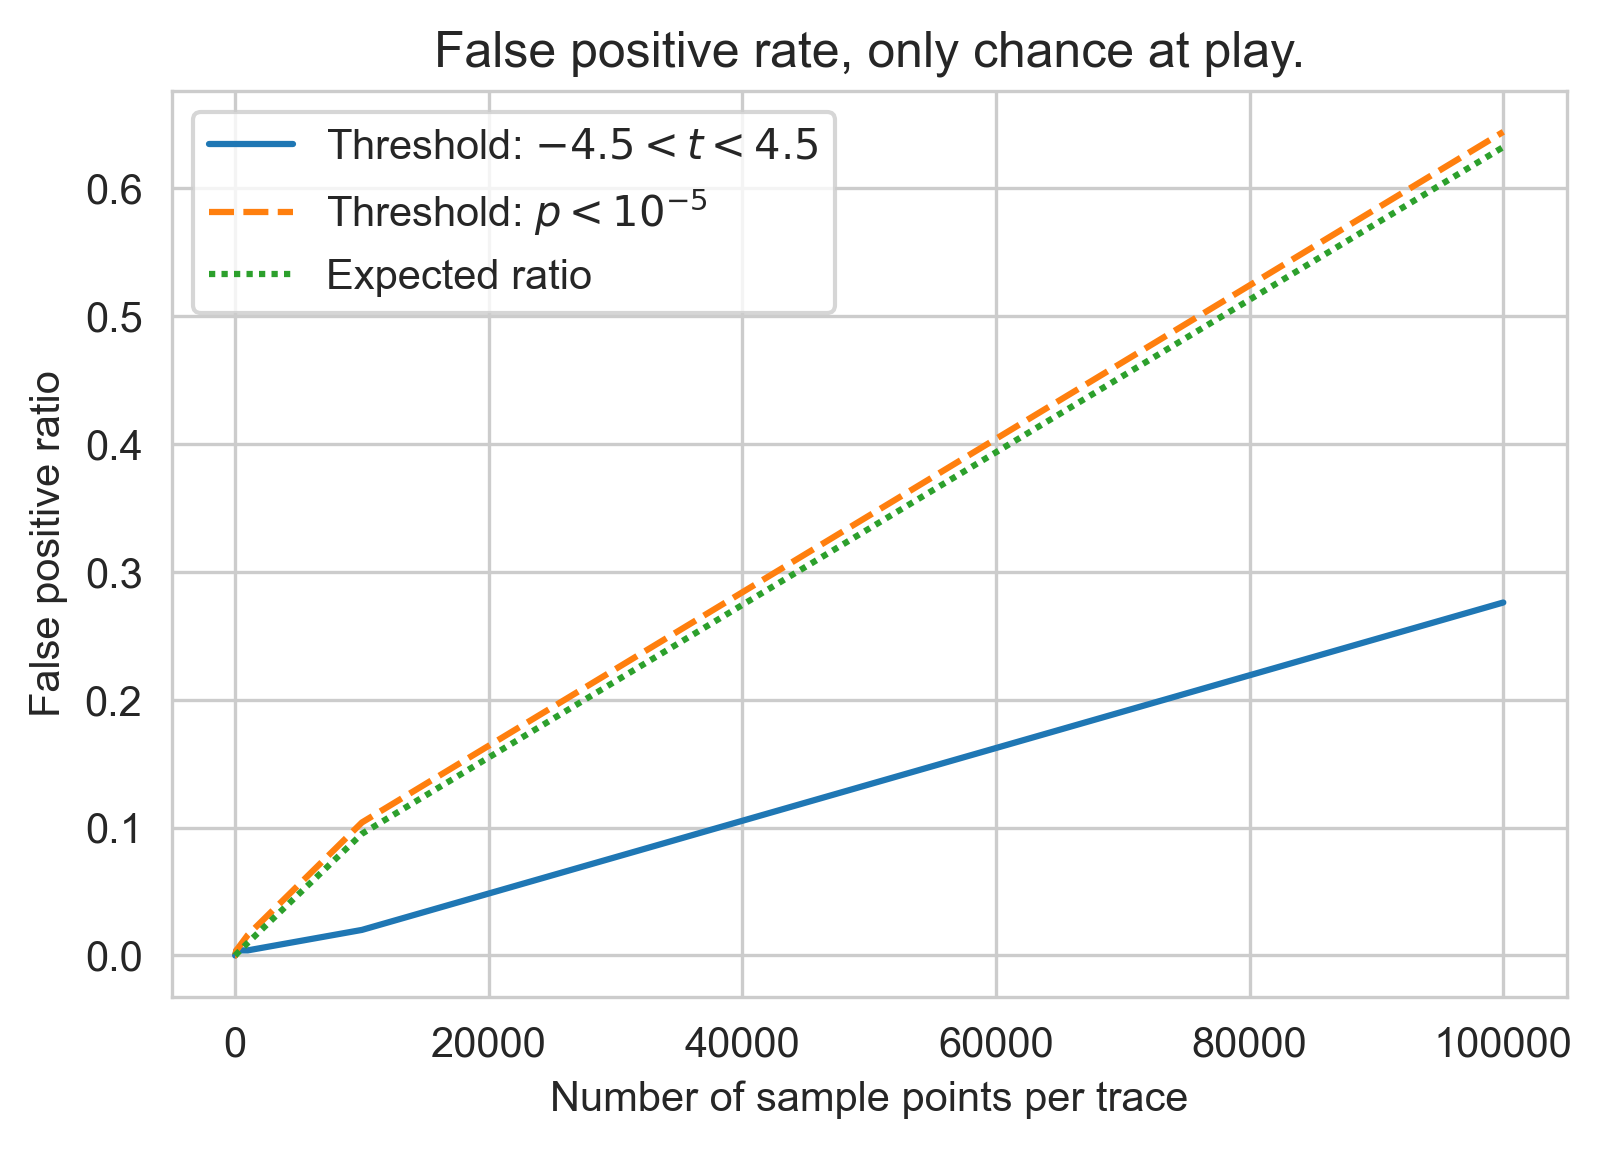

In [41]:
DATA = {
    "Threshold: $-4.5 < t < 4.5$": MIN_P[:, 0] / NUM_TIMES,
    "Threshold: $p < 10^{-5}$": MIN_P[:, 1] / NUM_TIMES,
    "Expected ratio": np.array([1 - (1 - 10 ** -5) ** p for p in INDEX]),
}

G = sns.lineplot(data=pd.DataFrame(DATA).set_index(INDEX))
G.set(xlabel="Number of sample points per trace",
      ylabel="False positive ratio",
      title="False positive rate, only chance at play.")
G.figure.savefig("img/fpr_chance.png")